In [1]:
# import aplpy
import os
import sys
import warnings
import scipy.ndimage as snd

import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

from aplpy.core import FITSFigure
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, FK5
from glob import glob
from matplotlib import ticker
from matplotlib.ticker import PercentFormatter
from casatasks import imstat

PATH = set(sys.path)
append = [
    f"{os.environ['HOME']}/git_repos/misc_scripts_n_tools/fits_related/",
    f"{os.environ['HOME']}/git_repos/misc_scripts_n_tools/qu_pol/scrappy/"
]

for ap in append:
    if not PATH.issuperset(ap):
        sys.path.append(ap)

import random_fits_utils as rfu
from utils.rmmath import frac_polzn_error, frac_polzn


warnings.filterwarnings("ignore", module="astropy")


FIGSIZE = (16,9)
EXT = ".png"
DPI = 100


# Where we are dumping the output
PFIGS = "paper-figs-aplpy"


# For Polarization angles IAU Convention for 0 degree is at NORTH, 
# but angles in matplotlIb start at x=0. Thus correct angle must be offset
ANGLE_OFFSET = 90


# by how much to rotate the e vectors and include the mpl offset here
ROT = 90 + ANGLE_OFFSET

In [2]:
def fix_aplpy_fits(aplpy_obj, dropaxis=2):
    """This removes the degenerated dimensions in APLpy 2.X...
    The input must be the object returned by FITSFigure().
    `dropaxis` is the index where to start dropping the axis (by default it assumes the 3rd,4th place).
    """
 
    # temp_wcs = aplpy_obj._wcs.dropaxis(dropaxis)
    # temp_wcs = temp_wcs.dropaxis(dropaxis)
    # aplpy_obj._wcs = temp_wcs

    if aplpy_obj._wcs.naxis>2:
        for _ in range(aplpy_obj._wcs.naxis-2):
            aplpy_obj._wcs = aplpy_obj._wcs.dropaxis(2)

    return aplpy_obj



def remove_extra_axes(fname):
    print("Clean out the axis")
    with fits.open(fname, mode='update') as hdu:
        if "HISTORY" in hdu[0].header:
            del hdu[0].header["HISTORY"]
        for kw in ("CTYPE", "CRVAL", "CRPIX", "CDELT", "CUNIT"):
            for n in 3, 4:
                if f"{kw}{n}"in hdu[0].header:
                    hdu[0].header.remove(f"{kw}{n}")
        hdu.flush()



def get_data(fname):
    """Get the data from a fits image"""
    data = fits.getdata(fname).squeeze()
    return data



def contour_levels(start, data):
    """Generate contour levels"""
    # ratio between the levels is root(2)
    print("Generating contour levels")
    levels = [start * np.sqrt(2)**_ for _ in range(30)]
    levels = np.ma.masked_greater(levels, np.nanmax(data)).compressed()
    return levels


def basic_figure(this, vmin=None, vmax=None, cmap="magma", cbar_loc="right"):
    """
    cbar_loc: location of the colorbar
        Determines whether a colorbar is added or not
    """
    fix_aplpy_fits(this)

    # add the beam
    # this.add_beam()

    this.show_colorscale(cmap=cmap, vmin=vmin, vmax=vmax)
    this.tick_labels.set_font(size=20)


    # grid settings
    this.add_grid()
    # this.grid.set_color(’white’)
    # this.grid.set_alpha(0.8)
    # this.grid.set_linestyle(’solid’)
    # this.grid.set_linewidth(1)


    # zoom to the center  
    this.recenter(ra_deg, dec_deg, width=0.15, height=0.1)


    if cbar_loc is not None:
        # colorbar settings
        this.add_colorbar()
        this.colorbar.set_width(0.3)
        this.colorbar.set_location(cbar_loc)
        this.colorbar.set_pad(0)
        this.colorbar.set_axis_label_font(size=20, weight="normal")
        # this.colorbar.set_axis_label_rotation(270)


    # scalebar on top of the image, i.e that line that shows distance in parsec
    # https://python4esac.github.io/plotting/aplpy.html
    # this.add_scalebar(5/60.)
    # this.scalebar.set_label('5 arcmin')
    # this.scalebar.set_color('white')
    # this.scalebar.set_corner('top left')
    # this.scalebar.set_length(17/60.)
    # this.scalebar.set_label('1 parsec')

    return this


def make_inset(this, vmin=None, vmax=None, cmap="magma", center=None, no_ticks=True):
    """
    Some basic setup for insets
    center: dict
        ra, dec and radius in degree given with the following keys.
        x: ra, y: dec, width: width, height: height, radius: radius
    """
    this = fix_aplpy_fits(this)
    this.recenter(**center)
    this.show_colorscale(cmap=cmap, vmin=vmin, vmax=vmax)
    
    if no_ticks:
        this.ticks.hide()
        this.tick_labels.hide()
        this.axis_labels.hide()
    else:
        this.ticks.show()
        this.tick_labels.set_font(size="x-large")
    
    return this



def beautify_histogram(hist, title="some distribution", label="Data count", dim="x"):

    if dim=="x":
        getattr(hist, f"{dim}axis").tick_bottom()
        hist.yaxis.tick_right()
    else:
        getattr(hist, f"{dim}axis").tick_left()
        hist.xaxis.tick_top()
    getattr(hist, f"{dim}axis").set_visible(True)
    getattr(hist, f"{dim}axis").set_major_formatter(PercentFormatter(xmax=.1))
    setattr(hist.axes, f"set_{dim}label", label)

    hist.minorticks_on()
    hist.set_title(title)
    hist.legend()
    return hist


def make_hdu(fname, data):
    hdu = fits.PrimaryHDU(data=data, header=fits.getheader(fname))
    return hdu

In [3]:

spectest = "/home/andati/pica/reduction/testing_spectra"

envs = {"prods": "products"}


envs.update(dict(
    orig_cubes=f"{envs['prods']}/original-cubes",
    sel_cubes=f"{envs['prods']}/selection-cubes",
    conv_cubes=f"{envs['prods']}/conv-selection-cubes",
    plots=f"{envs['prods']}/beam-plots",
    spis=f"{envs['prods']}/spi-fitting",
    imgs="relevant-images",
    mask_dir="/home/andati/pica/reduction/experiments/emancipation/masks"
))


# set those env variables
for key, value in envs.items():
    if key not in os.environ:
        os.environ[key] = value


if not os.path.isdir(PFIGS):
    os.makedirs(PFIGS)

In [4]:
cubes = sorted(glob(
        os.path.join(".", os.environ["conv_cubes"], "*-image-cube.fits")
        ))[:3]

imgs = sorted(glob("./*-mfs.fits"))
mask_dir = os.environ["mask_dir"]
products = os.environ["prods"]

mask = f"{mask_dir}/true_mask.fits"
jet_mask = f"{mask_dir}/jet.fits"
prefix = "initial"

rm_map = os.path.join(products, f"{prefix}-RM-depth-at-peak-rm.fits")
fp_map = os.path.join(products, f"{prefix}-FPOL-at-max-lpol.fits")
lp_map = os.path.join(products, f"{prefix}-max-LPOL.fits")

pangle_map = os.path.join(products, f"{prefix}-PA-pangle-at-peak-rm.fits")
spi_map = os.path.join(products, f"spi-fitting/spi-map.alpha.fits")


emask = f"{mask_dir}/east-lobe.fits"
wmask = f"{mask_dir}/west-lobe.fits"
lmask = f"{mask_dir}/lobes.fits"
smask = f"{mask_dir}/true_mask.fits"

vla_lband_rm = f"{spectest}/from_rick/4k-proj/band-l-and-c-LCPIC-10.RM10.2.FITS-projected.fits"
r_emask = f"{mask_dir}/rick-east-rm2.fits"
r_wmask = f"{mask_dir}/rick-west-rm2.fits"

idata = rfu.read_image_cube(cubes[0])["data"]
qdata = rfu.read_image_cube(cubes[1])["data"]
udata = rfu.read_image_cube(cubes[2])["data"]

chandra = [
    f"{spectest}/from_martin/chandra.fits",
    f"{spectest}/from_martin/chandra-jet.fits"
    ]



# for centering

# convert RA to dec
ra = "5h19m50s"
dec = "-45d46m44s"

# setting an offset so that the image is centered well
# this is in degrees
offset = -0.01

sk = SkyCoord(f"{ra} {dec}", frame=FK5)
ra_deg, dec_deg = sk.ra.deg+offset, sk.dec.deg


In [5]:
# total intensity maps mostly

for item in [fp_map, lp_map, rm_map, spi_map]:
    remove_extra_axes(item)



radio_data_mkat = get_data(imgs[0])
mkat_4mjy_mask = np.ma.masked_less(radio_data_mkat, 4e-3)
mkat_4mjy_mask.fill_value = np.nan
# make only the valid items 1. We are making a mulitplication mask, not an image mask
mkat_4mjy_mask = (mkat_4mjy_mask.filled()*0) + 1

# radio_data_vla = get_data(imgs[0])
# radio_data_atca = get_data(imgs[0])

xray_data = get_data(chandra[0])

radio_levels = contour_levels(4e-3, radio_data_mkat)
xray_levels = contour_levels(4e-8, get_data(chandra[0]) )

Clean out the axis
Clean out the axis
Clean out the axis
Clean out the axis
Generating contour levels
Generating contour levels


In [6]:
def table2_core_flux_wfreq(cube, region, output=None):
    """
    Monitor Change in the flux of the core with frequency

    cube: str
        Name of input i image cube
    region: str
        Region under investigation e.g pica core
        Pass the name of this CTRF region file

    """

    """
    see: https://casa.nrao.edu/docs/TaskRef/imstat-task.html
    # These are the display axes, the calculation of statistics occurs  
    # for each (hyper)plane along axes not listed in the axes parameter,  
    # in this case axis 2 (the frequency axis)  
    """
    
    if output is None:
        output=f"{PFIGS}/2-table{EXT}"

    stats = imstat(cube, region=region, axes=[0,1])
    flux = stats["flux"]
    mean = stats["mean"]
    sigma = stats["sigma"]
    chans = np.arange(flux.size)

    fig, ax = plt.subplots(figsize=FIGSIZE)
    ax.plot(chans, flux, "ko", label="flux [Jy]")
    ax.plot(chans, snd.gaussian_filter(flux, sigma=3), "k--",
        label="flux fit")
    # ax.errorbar(chans, mean, yerr=sigma)
    ax.plot(chans, mean, "bo", label=r"$\mu$ [Jy/beam]")
    ax.plot(chans, snd.gaussian_filter(mean, sigma=3), "b--",
        label=r"$\mu$ fit ")
    ax.fill_between(chans, mean-sigma, mean+sigma, color="b",
        alpha=0.3, label=r"$\sigma$")

    ax.set_xlabel("Channel")
    ax.set_ylabel("Spectral fluxes*")
    plt.title("Flux change in Pictor A nucleus")
    plt.legend()
    print(f"Saving plot: {output}")
    
    plt.savefig(output, dpi=DPI)
    plt.close("all")



In [7]:
def table3_lobe_flux_wfreq(elobe, wlobe, output=None, smooth_sigma=10):
    """
    Monitor change of lobes' flux with frequncy
    (e|w)lobe:
        Cube of the eastern or western lobe. These can be generated using
        Fitstools in the following way:
        fitstool.py --prod i-image-cube.fits masks/west-lobe.fits -o west-lobe-cube.fits
        Note that we multiply the image x mask and not mask x image!

    see: https://casa.nrao.edu/docs/TaskRef/imstat-task.html
    # These are the display axes, the calculation of statistics occurs  
    # for each (hyper)plane along axes not listed in the axes parameter,  
    # in this case axis 2 (the frequency axis)  
    """
    from casatasks import imstat

    if output is None:
        output=f"{PFIGS}/3-table-lobe-fluxes.png"

    estats = imstat(elobe, axes=[0,1], stretch=True)
    wstats = imstat(wlobe, axes=[0,1], stretch=True)
    
    eflux = estats["flux"]
    wflux = wstats["flux"]

    chans = np.arange(eflux.size)

    fig, ax = plt.subplots(figsize=FIGSIZE, ncols=2, sharex=True)

    # Eastern lobe
    ax[0].plot(chans, eflux, "bo", label="flux [Jy]")
    ax[0].plot(
        chans, snd.gaussian_filter(eflux, sigma=smooth_sigma),
        "r--", label=fr"Gaussian fit {smooth_sigma}$\sigma$")

    ax[0].set_xlabel("Channel")
    ax[0].set_ylabel("Spectral fluxes*")
    ax[0].set_title(f"Eastern Lobe, Total Flux sum: {np.sum(eflux):.3f}")
    ax[0].minorticks_on()

    # Western lobe
    ax[1].plot(chans, wflux, "bo", label="flux [Jy]")
    ax[1].plot(
        chans, snd.gaussian_filter(wflux, sigma=smooth_sigma),
        "r--", label=fr"Gaussian fit {smooth_sigma}$\sigma$")

    ax[1].set_xlabel("Channel")
    ax[1].set_ylabel("Spectral fluxes*")
    ax[1].set_title(f"Western Lobe, Total Flux sum: {np.sum(wflux):.3f}")
    ax[1].minorticks_on()

    fig.suptitle("Flux change in Pictor A lobes")
    plt.legend()
    print(f"Saving plot: {output}")
    
    plt.savefig(output, dpi=DPI)
    plt.close("all")

In [8]:

def fig_3b_chandra():
    fig = plt.figure(figsize=FIGSIZE)
    fig = FITSFigure(imgs[0], figure=fig)
    fig = basic_figure(fig, vmin=0, vmax=0.3)


    # show regions useful for the RM map
    # fig.show_regions(f"{mask_dir}/important_regions/all-components.reg")

    fig.colorbar.set_axis_label_text("Flux (Jy/beam)")

    # show contours
    fig.show_contour(chandra[0], colors="green", smooth=1, kernel="gauss",
        levels=xray_levels, linewidths=1)


# fig_3b_chandra()

In [9]:
def fig_3b_chandra_jet_subplots(oname=None):
    fig = plt.figure(figsize=FIGSIZE)

    fig1 = FITSFigure(imgs[0], figure=fig, subplot=[0, 0, 0.55, 1])
    fig1 = basic_figure(fig1, vmin=0, vmax=.2, cbar_loc="top")

    fig1.colorbar.set_axis_label_text("Flux (Jy/beam)")

    # radio contours
   
    # fig1.show_contour(radio_data_mkat, colors="green", smooth=1, kernel="gauss",
    #     levels=radio_levels, linewidths=0.5
    #     )

    # jet on the side
    xmin, dx = 0.56, 0.4
    ymin, dy = 0, 1
    jet = FITSFigure(imgs[0], figure=fig, subplot=[xmin, ymin, dx, dy])
    jet = make_inset(jet, cmap="magma", vmin=0, vmax=0.05,
        center=dict(x=ra_deg-.04, y=dec_deg, radius=0.037), no_ticks=False,
        )

    jet.show_colorscale(cmap="magma", vmin=4e-3, vmax=0.08, stretch="power", exponent=2)
    
    jet.show_contour(radio_data_mkat, colors="green", smooth=1, kernel="gauss",
        levels=radio_levels, linewidths=0.5)
    jet.tick_labels.set_yposition("right")
    # jet.tick_labels.hide()
    
    

    # eastern hotspot
    ehs = FITSFigure(imgs[0], figure=fig, subplot=[0.01, 0.7, 0.27, 0.27])
    ehs = make_inset(ehs, cmap="magma", vmin=0, vmax=0.5,
        center=dict(x=ra_deg+.07, y=dec_deg-0.02, radius=0.01)
        )
    
    ehs.show_contour(radio_data_mkat, colors="green", smooth=1, kernel="gauss",
        levels=radio_levels, linewidths=0.5)
    ehs.show_colorscale(cmap="magma", vmin=0, vmax=1)


    # chandra contours
    # fig1.show_contour(chandra[0], colors="green", smooth=1, kernel="gauss",
    #     levels=xray_levels, linewidths=0.5
    #     )

    # jet.show_contour(chandra[0], colors="green", smooth=1, kernel="gauss",
    #     levels=xray_levels, linewidths=0.5)

    # ehs.show_contour(chandra[0], colors="green", smooth=1, kernel="gauss",
    #     levels=xray_levels, linewidths=0.5)

    fig1.ax.indicate_inset_zoom(ehs.ax, edgecolor="yellow", lw=2)
    # fig1.ax.indicate_inset_zoom(jet.ax, edgecolor="yellow", lw=2)


    if oname is None:
        oname = f"{PFIGS}/3-pictor-a{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")
    


# fig_3b_chandra_jet_subplots()

In [10]:
def figure_4b_intensity_contours(oname=None):
    fig = plt.figure(figsize=FIGSIZE)
    fig1 = FITSFigure(imgs[0], figure=fig)
    fig1 = basic_figure(fig1, vmin=0, vmax=0.7, cbar_loc="right")

    # fig1.show_contour(radio_data_mkat, colors="green", smooth=13, kernel="gauss",
    #     levels=radio_levels, linewidths=1)
    
    fig1.ax.contour(
            snd.gaussian_filter(radio_data_mkat, sigma=13),
            colors="g", origin="lower", levels=radio_levels, linewidths=1)

    fig1.colorbar.set_axis_label_text("Flux [Jy/beam]")

    if oname is None:
        oname = f"{PFIGS}/4b-intensity-contours{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")

# figure_4b_intensity_contours()

In [11]:
def figure_5b_spi_wintensity_contours(oname=None):
    
    fig = plt.figure(figsize=FIGSIZE)

    spi_data = get_data(spi_map) * mkat_4mjy_mask
    
    fig1 = FITSFigure(
        make_hdu(spi_map, spi_data),
        figure=fig)

    fig1 = basic_figure(fig1, vmin=-1.7, vmax=-0.5, cbar_loc="right", cmap="coolwarm")
   
    # fig1.show_contour(radio_data_mkat, colors="green", smooth=13, kernel="gauss",
    #     levels=radio_levels, linewidths=1)
   
    fig1.ax.contour(
            snd.gaussian_filter(radio_data_mkat, sigma=13),
            colors="g", origin="lower", levels=radio_levels, linewidths=1)
   
    fig1.colorbar.set_axis_label_text("Spectral index")

    if oname is None:
        oname = f"{PFIGS}/5b-spi-intensity-contours{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")

# figure_5b_spi_wintensity_contours()

In [12]:
def figure_8_ti_magnetic_fields_contours(oname=None):
    fig = plt.figure(figsize=FIGSIZE)

    fig1 = FITSFigure(WCS(fits.getheader(fp_map)), figure=fig)
    fig1 = basic_figure(fig1, cbar_loc=None)

    fig1.ax.contour(radio_data_mkat,
            colors="k", linewidths=0.5, origin="lower", levels=radio_levels)
       
    bx = fig1.ax.contourf(
        radio_data_mkat ,
        cmap="coolwarm", origin="lower", levels=radio_levels,
        locator=ticker.LogLocator()
        )
    
    fig.colorbar(bx, pad=0, label="Flux [Jy/beam]",
        drawedges=False, location="right")
    
    
    fp_data = rfu.get_masked_data(fp_map, smask)
    angle_data = rfu.get_masked_data(pangle_map, smask)
    
    if "rad" in fits.getheader(pangle_map)["BUNIT"].lower():
            angle_data = np.rad2deg(angle_data)
    
    # rotate the e vectors 
    angle_data = angle_data + ROT

    skip = 7
    slicex = slice(None, fp_data.shape[0], skip)
    slicey = slice(None, fp_data.shape[-1], skip)
    col, row = np.mgrid[slicex, slicey]

    # get M vector by rotating E vector by 90
    angle_data = angle_data[slicex, slicey]
    fp_data = fp_data[slicex, slicey]

    # nornalize this
    
    scales = fp_data / np.ma.max(fp_data)

    # scale as amplitude
    u = scales * np.cos(angle_data)
    v = scales * np.sin(angle_data)
    # u = v = np.ones_like(angle_data) * scales

    fig1.ax.quiver(
        row, col, u, v, angles=angle_data, pivot='tail', headlength=0,
        width=0.0012, scale=20, headwidth=1, color="black")
    
    if oname is None:
        oname = f"{PFIGS}/8-ti-contours-mfs{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")


# figure_8_ti_magnetic_fields_contours()

In [13]:
def figure_8b_dop_magnetic_fields_contours(oname=None):

       # masking the data with nans upto 4mjy
    fp_data = get_data(fp_map) * mkat_4mjy_mask
    angle_data = get_data(pangle_map) * mkat_4mjy_mask

    fp_hdu = make_hdu(fp_map, fp_data)


    fig = plt.figure(figsize=FIGSIZE)
    
    fig1 = FITSFigure(fp_hdu, figure=fig)
    fig1 = basic_figure(fig1, cmap="coolwarm", vmin=0, vmax=0.7)
    
    fig1.show_contour(radio_data_mkat, 
        colors="k", levels=radio_levels, linewidths=0.5)


    fig1.colorbar.set_axis_label_text("Degree of polarisation") 

    
    if "rad" in fits.getheader(pangle_map)["BUNIT"].lower():
        print("converting radians to degrees")
        angle_data = np.rad2deg(angle_data)
    
    # rotate the e vectors 
    angle_data = angle_data + ROT

    skip = 7
    slicex = slice(None, fp_data.shape[0], skip)
    slicey = slice(None, fp_data.shape[-1], skip)
    col, row = np.mgrid[slicex, slicey]

    # get M vector by rotating E vector by 90
    angle_data = angle_data[slicex, slicey]
    
    scales = 0.03

    # scale as amplitude
    # remember to mask these also so that the arrows are confined within the source
    u = np.full_like(angle_data, scales)
    u[np.where(np.isnan(angle_data))] = np.nan
    v = u

    # from ipdb import set_trace
    # set_trace()
    fig1.ax.quiver(
        row, col, u, v, angles=angle_data, pivot='tail', headlength=0,
        width=0.0012, scale=5, headwidth=1, color="black")
    
    if oname is None:
        oname = f"{PFIGS}/8-dop-contours-mfs{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")


# figure_8b_dop_magnetic_fields_contours()

In [14]:
def figure_9a_fractional_poln(oname=None):
    fp_data = get_data(fp_map) * mkat_4mjy_mask
    
    fig = plt.figure(figsize=FIGSIZE)

    fig1 = FITSFigure(make_hdu(fp_map, fp_data), figure=fig)
    
    fig1 = basic_figure(fig1, vmin=0, vmax=0.6, cbar_loc="right", cmap="coolwarm")
    # fig1.show_contour(radio_data_mkat, colors="green", levels=radio_levels)
    fig1.colorbar.set_axis_label_text("Degree of Polarisation")
    # fig1.set_nan_color("black")

    if oname is None:
        oname = f"{PFIGS}/9a-dop-mfs{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")

# figure_9a_fractional_poln()

In [15]:
def figure_10_linear_poln(oname=None):

    lp_data = get_data(lp_map) * mkat_4mjy_mask
    
    fig = plt.figure(figsize=FIGSIZE)

    fig1 = FITSFigure(make_hdu(lp_map, lp_data), figure=fig)

    fig1 = basic_figure(fig1, vmin=5e-3, vmax=5e-2, cbar_loc="right", cmap="coolwarm")
    fig1.show_contour(radio_data_mkat, colors="k", levels=radio_levels, linewidths=0.5)
    fig1.colorbar.set_axis_label_text("Linear polarised intensity")
    # fig1.set_nan_color("black")

    if oname is None:
        oname = f"{PFIGS}/10-lpol-mfs{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")

# figure_10_linear_poln()

In [16]:
def figure_14_depolarisation(oname=None):
    i_data = fits.getdata(cubes[0]).squeeze()[[0,-1]]
    q_data = fits.getdata(cubes[1]).squeeze()[[0,-1]]
    u_data = fits.getdata(cubes[2]).squeeze()[[0,-1]]


    fpol = np.divide(np.abs(q_data + 1j*u_data), i_data) * mkat_4mjy_mask
    depoln = fpol[0]/fpol[-1] 

    # manually create hdu for aplpy, otherwise becomes problematic
    
    depoln_hdu = make_hdu(fp_map, depoln)

    fig = plt.figure(figsize=FIGSIZE)
    fig1 = FITSFigure(depoln_hdu, figure=fig)
    
    fig1 = basic_figure(fig1, vmin=0, vmax=2, cbar_loc="right", cmap="coolwarm")
    fig1.colorbar.set_axis_label_text("Depolarization ratio")

    # fig1.show_contour(radio_data_mkat, colors="green", levels=radio_levels, linewidths=1)

    if oname is None:
        oname = f"{PFIGS}/14-depolzn{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")   

# figure_14_depolarisation()
    

In [17]:
def figure_12_13_rm_lobes_histogram(oname=None):


    rm_data = get_data(rm_map) * mkat_4mjy_mask
    
    fig = plt.figure(figsize=FIGSIZE)

    fig1 = FITSFigure(make_hdu(rm_map, rm_data), figure=fig, subplots=[0.0, 0.0, .75, .75])


    fig1 = basic_figure(fig1, vmin=-60, vmax=60, cbar_loc="right", cmap="coolwarm")
    fig1.show_contour(radio_data_mkat, colors="black", levels=radio_levels, linewidths=0.5)
    fig1.colorbar.set_axis_label_text(r"Rotation measures rad/m$^{2}$")
    fig1.set_nan_color("grey")
    fig1.show_regions(f"{mask_dir}/important_regions/all-components-4pp.reg")
    
    fig1.colorbar.set_location("bottom")
    fig1.colorbar.set_pad(0.5)

    # entire source
    rm_lobes_data = rfu.get_masked_data(rm_map, lmask).compressed()
    # only west lobe
    w_lobe_data = rfu.get_masked_data(rm_map, wmask).compressed()
    # only east love
    e_lobe_data = rfu.get_masked_data(rm_map, emask).compressed()

    bins = 50
    log = False

    # current figure dimensions
    xmin, ymin, dx, dy = fig1.ax.get_position().bounds
    # [x, y, dx, dy]
    top_hist = fig.add_axes([xmin, ymin+dy, dx , 1-dy])
    top_hist.hist(rm_lobes_data, bins=bins, log=log,
        orientation="vertical",fill=False, ls="--", lw=1, edgecolor="red",
        density=True, label="Source RMs",
        histtype="step")
    top_hist.hist(e_lobe_data, bins=bins, log=log,
        orientation="vertical", fill=False, ls="-", lw=1, edgecolor="blue",
        density=True, label="East lobe",
        histtype="step")
    
    top_hist = beautify_histogram(
        top_hist,
        title="Eastern Lobe RM Distribution", 
        dim="y")
    
    right_hist = fig.add_axes([xmin+dx, ymin, 1-(xmin+dx), dy])
    right_hist.hist(rm_lobes_data, bins=bins, log=log,
        orientation="horizontal",fill=False, ls="--", lw=1,
        edgecolor="red",density=True, label="Source RMs",
        histtype="step")
    right_hist.hist(w_lobe_data, bins=bins, log=log,
        orientation="horizontal",fill=False, ls="-", lw=1,
        edgecolor="blue",density=True, label="West lobe",
        histtype="step")

    right_hist = beautify_histogram(
        right_hist,
        title="Western Lobe RM Distribution", 
        dim="x")


    if oname is None:
        oname = f"{PFIGS}/12-rm-lobes.png"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")
    


# figure_12_13_rm_lobes_histogram()

In [18]:
def figure_12_13_rm_lobes_histogram_rick(oname=None):

    
    rm_data = get_data(rm_map) * mkat_4mjy_mask
    fig = plt.figure(figsize=FIGSIZE)
    
    fig1 = FITSFigure(make_hdu(rm_map, rm_data), figure=fig, subplots=[0.0, 0.0, .75, .75])

    fig1 = basic_figure(fig1, vmin=-60, vmax=60, cbar_loc="right", cmap="coolwarm")
    fig1.show_contour(radio_data_mkat, colors="black", levels=radio_levels, linewidths=0.5)
    fig1.colorbar.set_axis_label_text(r"Rotation measures rad/m$^{2}$")
    fig1.show_regions(f"{mask_dir}/important_regions/all-components-4pp.reg")
    
    fig1.colorbar.set_location("bottom")
    fig1.colorbar.set_pad(0.5)

    # entire source
    rm_lobes_data = rfu.get_masked_data(rm_map, lmask).compressed()
    # only west lobe
    w_lobe_data = rfu.get_masked_data(rm_map, wmask).compressed()
    # only east lobe
    e_lobe_data = rfu.get_masked_data(rm_map, emask).compressed()

    rw_lobe = rfu.get_masked_data(vla_lband_rm, r_wmask).compressed()
    re_lobe = rfu.get_masked_data(vla_lband_rm, r_emask).compressed()

    bins = 50
    log = False

    # current figure dimensions
    xmin, ymin, dx, dy = fig1.ax.get_position().bounds
    # [x, y, dx, dy]
    top_hist = fig.add_axes([xmin, ymin+dy, dx , 1-dy])
    top_hist.hist(rm_lobes_data, bins=bins, log=log,
        orientation="vertical",fill=False, ls="--", lw=1, edgecolor="black",
        density=True, label="Source RMs",
        histtype="step")
    top_hist.hist(e_lobe_data, bins=bins, log=log,
        orientation="vertical", fill=False, ls="-", lw=1, edgecolor="blue",
        density=True, label="East lobe",
        histtype="step")
    top_hist.hist(re_lobe, bins=bins, log=log,
            orientation="vertical",fill=False, ls="-", lw=1,
            edgecolor="red",density=True, label="P97 West lobe",
            histtype="step")
    
    top_hist = beautify_histogram(
        top_hist,
        title="Eastern Lobe RM Distribution", 
        dim="y")
    
    right_hist = fig.add_axes([xmin+dx, ymin, 1-(xmin+dx), dy])
    right_hist.hist(rm_lobes_data, bins=bins, log=log,
        orientation="horizontal",fill=False, ls="--", lw=1,
        edgecolor="black",density=True, label="Source RMs",
        histtype="step")
    right_hist.hist(w_lobe_data, bins=bins, log=log,
        orientation="horizontal",fill=False, ls="-", lw=1,
        edgecolor="blue",density=True, label="West lobe",
        histtype="step")
    right_hist.hist(rw_lobe, bins=bins, log=log,
            orientation="horizontal", fill=False, ls="-", lw=1, edgecolor="red",
            density=True, label="P97 East lobe",
            histtype="step")

    right_hist = beautify_histogram(
        right_hist,
        title="Western Lobe RM Distribution", 
        dim="x")

    if oname is None:
        oname = f"{PFIGS}/12-rm-lobes-with-ricks{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")    


# figure_12_13_rm_lobes_histogram_rick()

In [19]:
def figure_rm_map(oname=None):
    
    rm_data = get_data(rm_map) * mkat_4mjy_mask
    fig = plt.figure(figsize=FIGSIZE)
    fig1 = FITSFigure(make_hdu(rm_map, rm_data), figure=fig)

    fig1 = basic_figure(fig1, vmin=-60, vmax=60, cbar_loc="right", cmap="coolwarm")
    
    # fig1.show_contour(radio_data_mkat, 
    #     colors="green", 
    #     # cmap="coolwarm", filled=True
    #     levels=radio_levels, linewidths=1)
    
    fig1.colorbar.set_axis_label_text(f"Rotation measures rad/$m^{2}$")

    if oname is None:
        oname = f"{PFIGS}/rm-map{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")
    
# figure_rm_map()

In [20]:
def figure_rm_map_b_with_mf(oname=None):

    rm_data = get_data(rm_map) * mkat_4mjy_mask
    fig = plt.figure(figsize=FIGSIZE)
    fig1 = FITSFigure(make_hdu(rm_map, rm_data), figure=fig)

    fig1 = basic_figure(fig1, vmin=-60, vmax=60, cbar_loc="right", cmap="coolwarm")
    # fig1.show_contour(radio_data_mkat, 
    #     colors="green", 
    #     # cmap="coolwarm", filled=True
    #     levels=radio_levels, linewidths=1)
    fig1.colorbar.set_axis_label_text(f"Rotation measures rad/$m^{2}$")


    fp_data = rfu.get_masked_data(fp_map, smask)
    angle_data = rfu.get_masked_data(pangle_map, smask)
    
    if "rad" in fits.getheader(pangle_map)["BUNIT"].lower():
            angle_data = np.rad2deg(angle_data)
    
    # rotate the e vectors 
    angle_data = angle_data + ROT

    skip = 7
    slicex = slice(None, fp_data.shape[0], skip)
    slicey = slice(None, fp_data.shape[-1], skip)
    col, row = np.mgrid[slicex, slicey]

    # get M vector by rotating E vector by 90
    angle_data = angle_data[slicex, slicey]
    fp_data = fp_data[slicex, slicey]

    # nornalize this
    
    scales = fp_data / np.ma.max(fp_data)

    # scale as amplitude
    u = scales * np.cos(angle_data)
    v = scales * np.sin(angle_data)
    # u = v = np.ones_like(angle_data) * scales

    fig1.ax.quiver(
        row, col, u, v, angles=angle_data, pivot='tail', headlength=0,
        width=0.0012, scale=20, headwidth=1, color="black")
    
    if oname is None:
        oname = f"{PFIGS}/rm-map-wmf{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")


# figure_rm_map_b_with_mf()

INFO: Setting slices=[0, 0] [aplpy.core]
paper-figs-aplpy/missing-flux.png


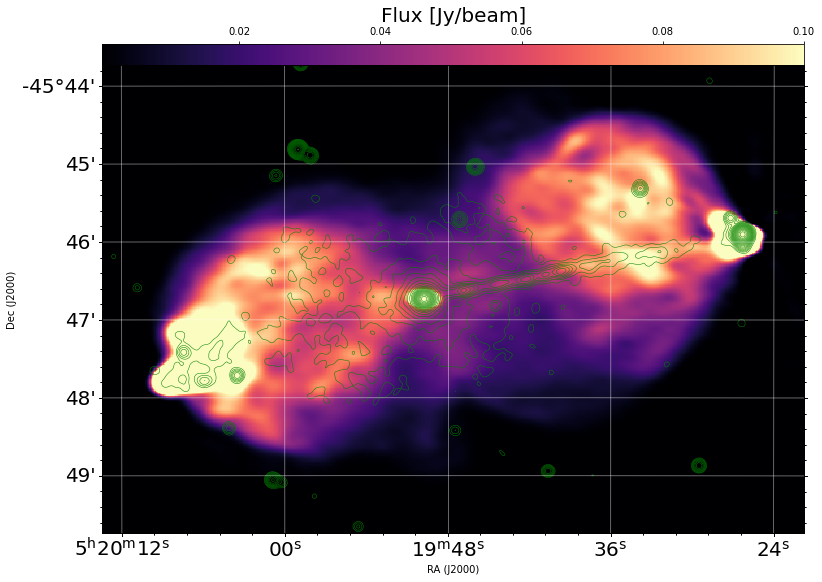

In [21]:

def missing_radio_flux(oname=None):
    fig = plt.figure(figsize=FIGSIZE)

    fig1 = FITSFigure(imgs[0], figure=fig)
    fig1 = basic_figure(fig1, vmin=0.6e-3, vmax=0.1, cbar_loc="top")


    # show contours
    fig1.show_contour(chandra[0], colors="green", smooth=1, kernel="gauss",
        levels=xray_levels, linewidths=0.5
        )

    
    fig1.colorbar.set_axis_label_text(f"Flux [Jy/beam]")

    if oname is None:
        oname = f"{PFIGS}/missing-flux{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")
    
missing_radio_flux()

In [22]:
def run_papermill():
    print("----------------------------")
    print("Running paper mill")
    print("----------------------------")
    
    # table2_core_flux_wfreq(cubes[0],
    #     region=f"{mask_dir}/important_regions/hotspots/core-ctrf")
    # table3_lobe_flux_wfreq(elobe=f"{products}/east-lobe-cube.fits",
    #     wlobe=f"{products}/west-lobe-cube.fits")
    
    fig_3b_chandra_jet_subplots()
    figure_4b_intensity_contours()
    figure_5b_spi_wintensity_contours()

    figure_8_ti_magnetic_fields_contours()
    figure_8b_dop_magnetic_fields_contours()
    figure_9a_fractional_poln()
    figure_10_linear_poln()
    figure_14_depolarisation()
    # figure_14_depolarisation_errmap()
    
    # Lobe stuff
    figure_12_13_rm_lobes_histogram()
    figure_12_13_rm_lobes_histogram_rick()


    figure_rm_map()
    figure_rm_map_b_with_mf()
    missing_radio_flux()

    print("----------------------------")
    print("Paper mill stopped")
    print("----------------------------")

----------------------------
Running paper mill
----------------------------
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]


INFO: Setting slices=[0, 0] [aplpy.core]


paper-figs-aplpy/3-pictor-a.png
INFO: Setting slices=[0, 0] [aplpy.core]
paper-figs-aplpy/4b-intensity-contours.png
paper-figs-aplpy/5b-spi-intensity-contours.png
INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  0.000e+00 [aplpy.core]
paper-figs-aplpy/8-ti-contours-mfs.png


converting radians to degrees
paper-figs-aplpy/8-dop-contours-mfs.png
paper-figs-aplpy/9a-dop-mfs.png


paper-figs-aplpy/10-lpol-mfs.png
paper-figs-aplpy/14-depolzn.png


/home/andati/git_repos/aplpy/aplpy/colorbar.py:100: UserWarning: Bottom colorbar not fully implemented
  warnings.warn("Bottom colorbar not fully implemented")
/home/andati/git_repos/aplpy/aplpy/colorbar.py:100: UserWarning: Bottom colorbar not fully implemented
  warnings.warn("Bottom colorbar not fully implemented")


paper-figs-aplpy/12-rm-lobes.png


Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x7f929f5dba60>
Traceback (most recent call last):
  File "/usr/lib/python3.8/weakref.py", line 58, in _cb
    callback(self)
  File "/home/andati/v_envs/casa6/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 239, in _remove_proxy
    del self.callbacks[signal][cid]
KeyError: 'changed'
/home/andati/git_repos/aplpy/aplpy/colorbar.py:100: UserWarning: Bottom colorbar not fully implemented
  warnings.warn("Bottom colorbar not fully implemented")
/home/andati/git_repos/aplpy/aplpy/colorbar.py:100: UserWarning: Bottom colorbar not fully implemented
  warnings.warn("Bottom colorbar not fully implemented")


paper-figs-aplpy/12-rm-lobes-with-ricks.png
paper-figs-aplpy/rm-map.png


Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x7f929ee4f3a0>
Traceback (most recent call last):
  File "/usr/lib/python3.8/weakref.py", line 58, in _cb
    callback(self)
  File "/home/andati/v_envs/casa6/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 239, in _remove_proxy
    del self.callbacks[signal][cid]
KeyError: 'changed'


paper-figs-aplpy/rm-map-wmf.png
INFO: Setting slices=[0, 0] [aplpy.core]
paper-figs-aplpy/missing-flux.png
----------------------------
Paper mill stopped
----------------------------


0

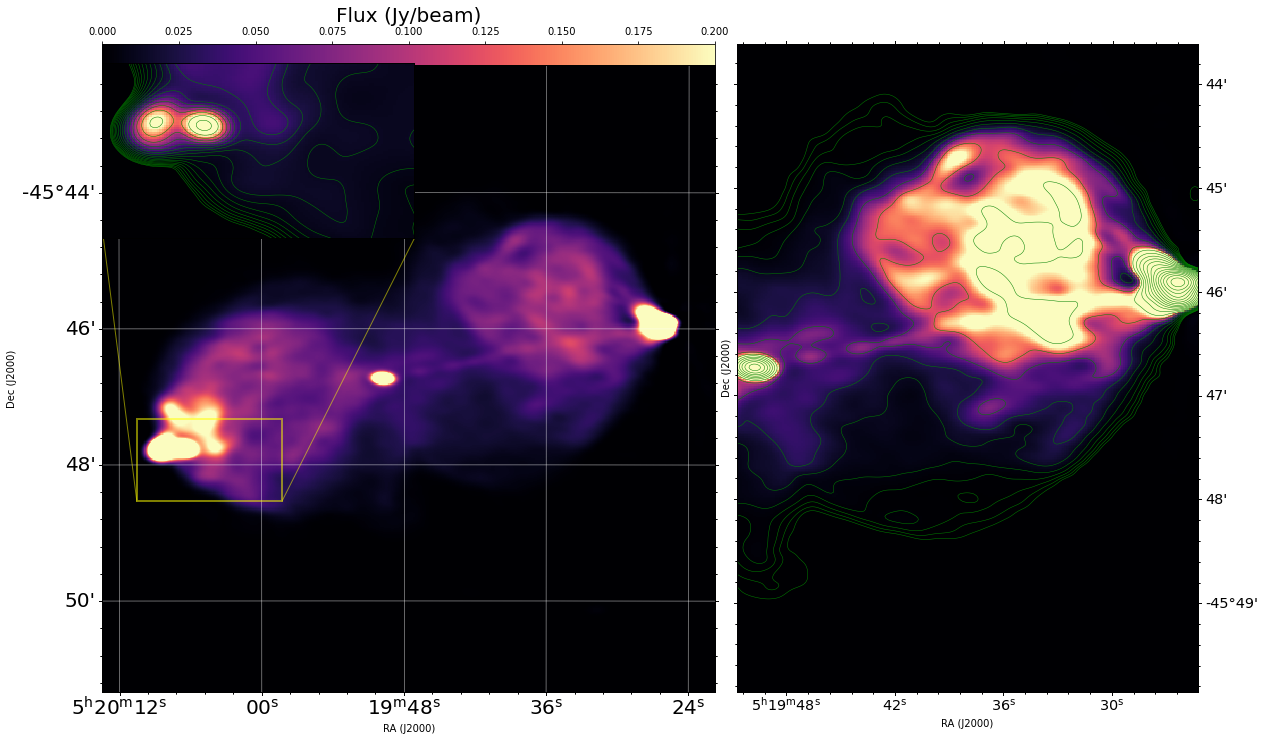

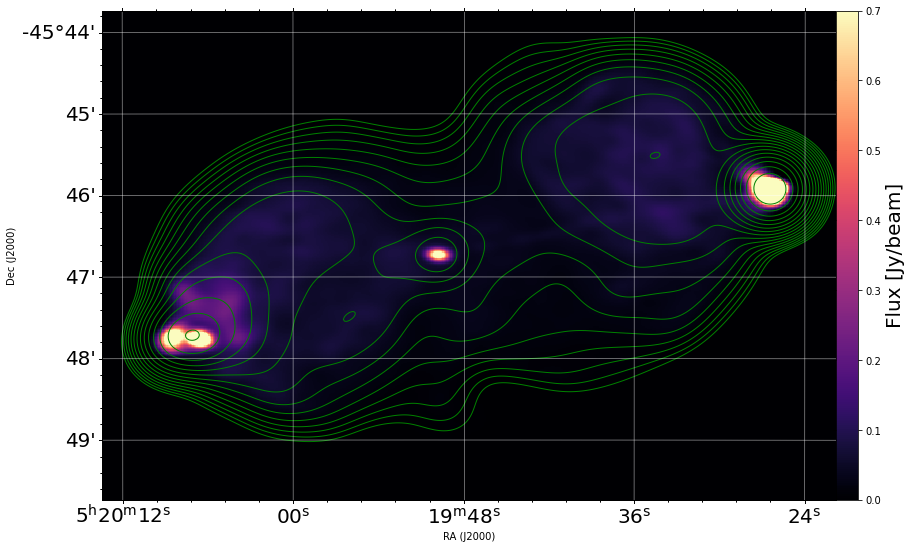

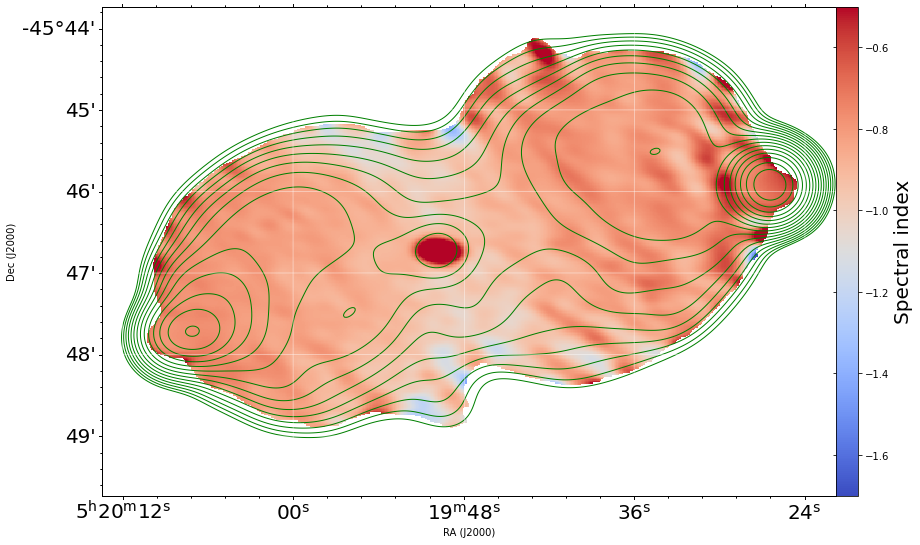

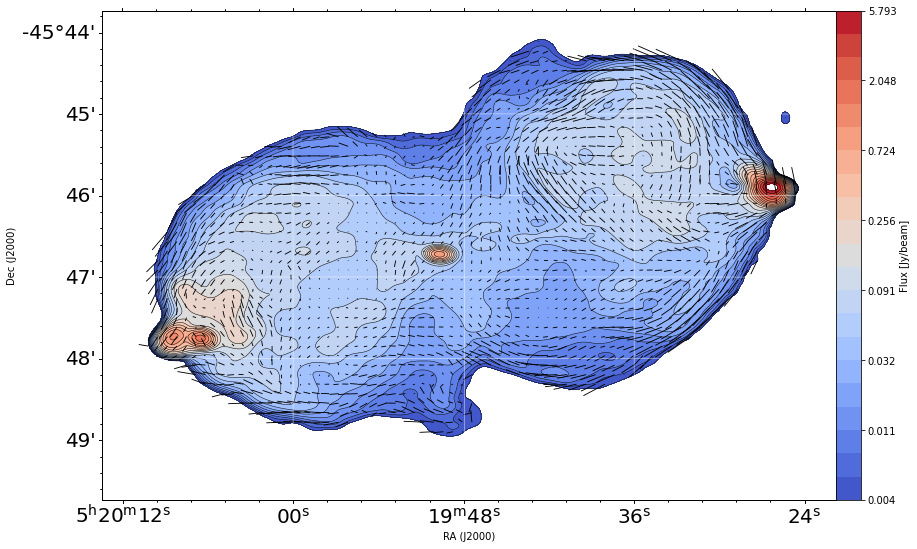

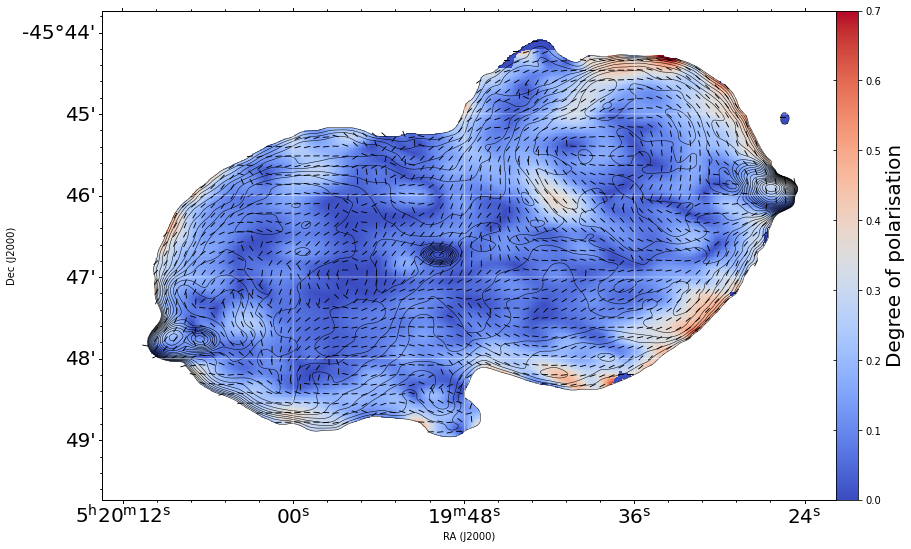

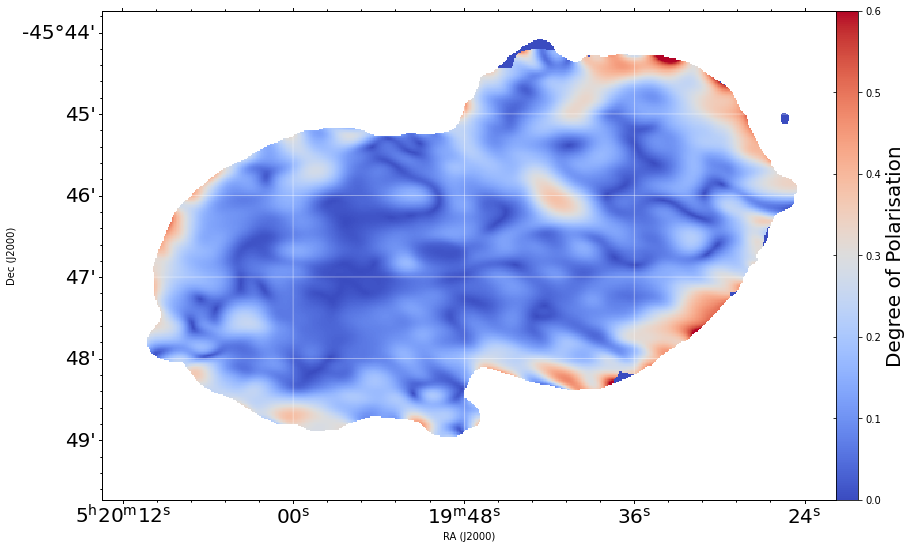

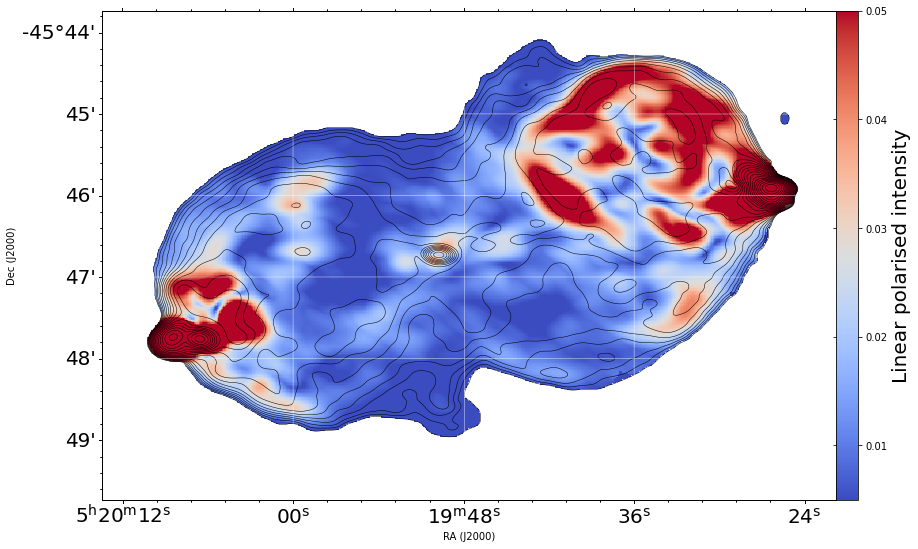

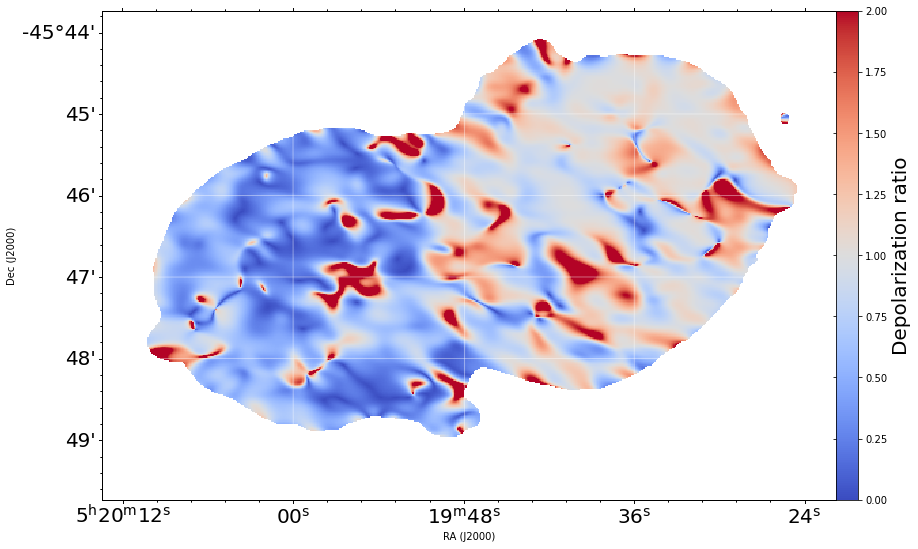

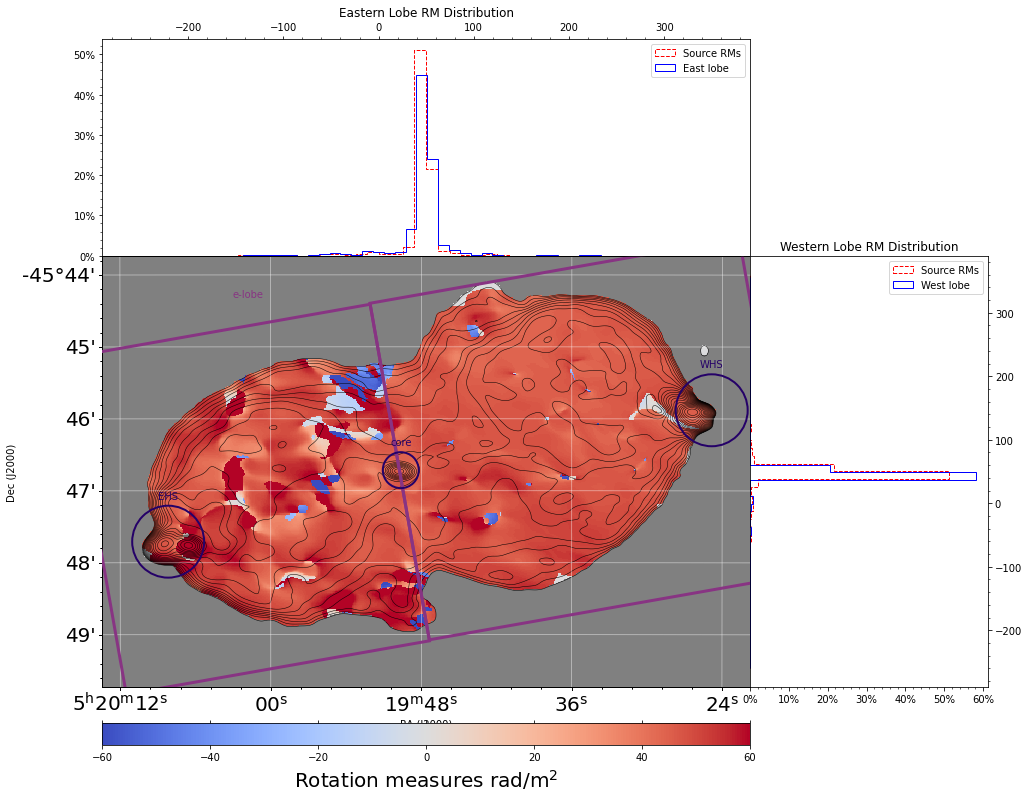

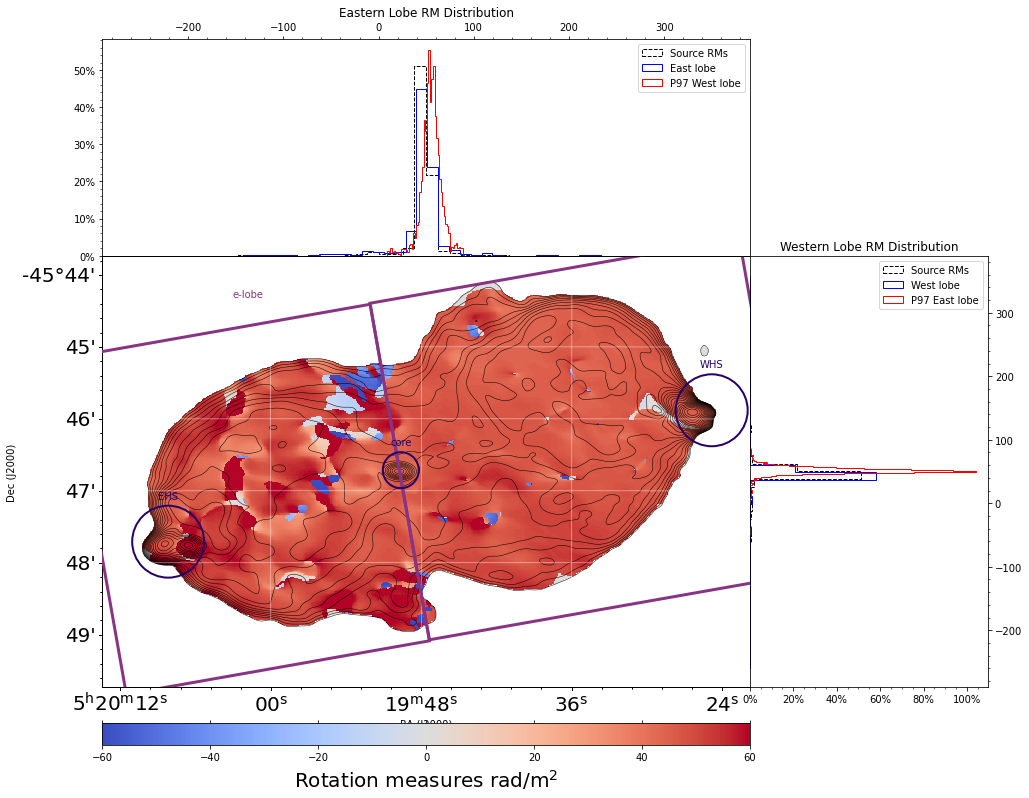

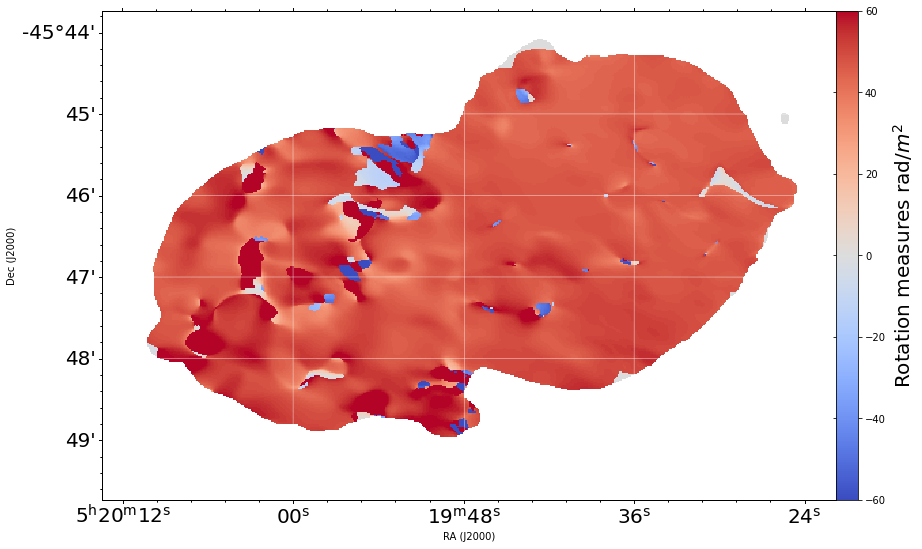

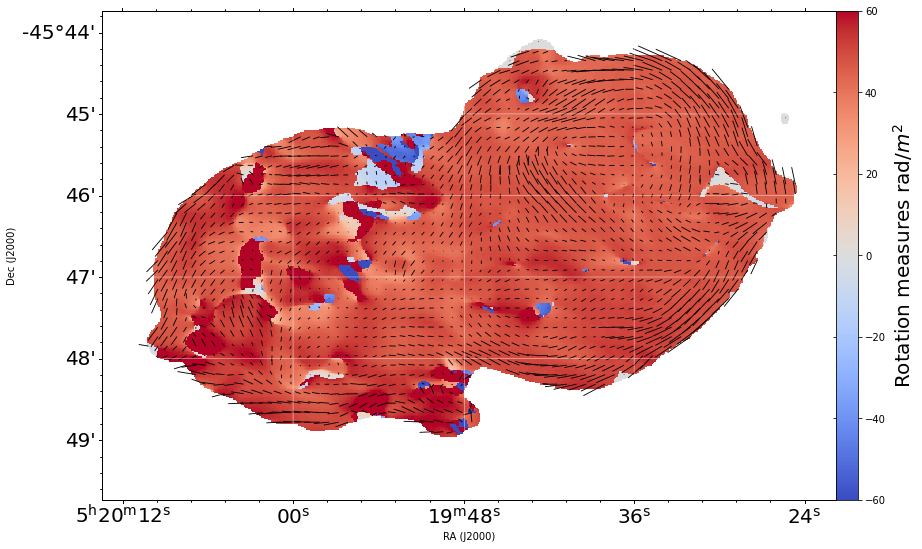

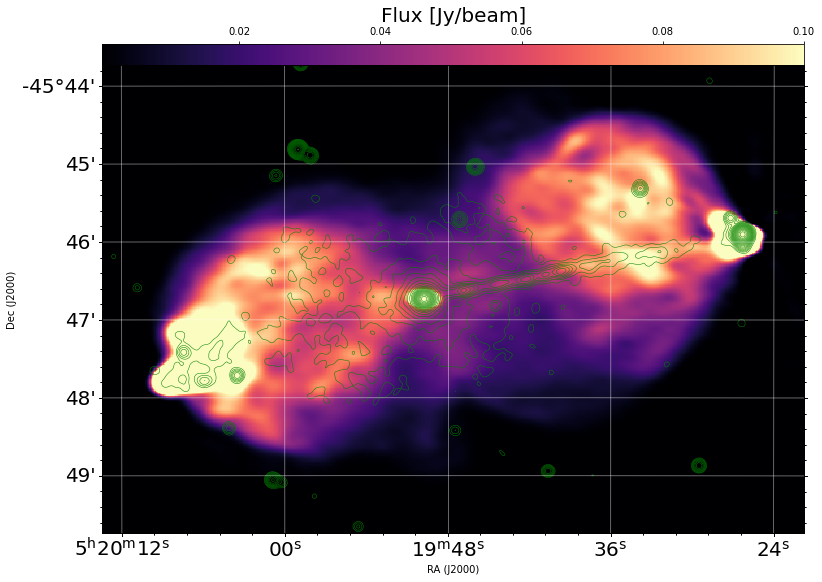

In [23]:
run_papermill()

os.system("rm casa*.log")
